# Failure Pareto for Test Results
This notebook creates a failure pareto report for test results. It ties into the **Test Monitor Service** for retrieving filtered test results, the **Notebook Execution Service** for running outside of Jupyterhub, and the **Test Monitor Reports page** at #testmonitor/reports for displaying results.

The parameters and output use a schema recognized by the Test Monitor Reports page, which can be implemented by various report types. The Failure Pareto notebook produces data that is best shown in a pareto chart.

### Imports
Import Python modules for executing the notebook. Pandas is used for building and handling dataframes. Scrapbook is used for recording data for the Notebook Execution Service. The SystemLink Test Monitor Client provides access to test result data for processing.

In [2]:
import copy
import datetime
import os
import pandas as pd
import requests
import scrapbook as sb
from dateutil import tz
from requests.packages.urllib3.exceptions import InsecureRequestWarning

import matplotlib.pyplot as plt
import systemlink.clients.nitestmonitor as testmon

requests.packages.urllib3.disable_warnings(InsecureRequestWarning)

### Parameters
- `result_ids`: IDs of the test results.

Parameters are also listed in the metadata for the parameters cell, along with their default values. The Notebook Execution services uses that metadata to pass parameters from the Test Monitor Reports page to this notebook. To see the metadata, select the code cell and click the wrench icon in the far left panel.

Sample metadata:

```json
{
  "papermill": {
    "parameters": {
      "result_ids": []
    }
  },
  "systemlink": {
    "namespaces": [],
    "parameters": [
      {
        "display_name": "result_ids",
        "id": "result_ids",
        "type": "string[]"
      }
    ],
    "version": 2
  },
  "tags": ["parameters"]
}
```

For more information on how parameterization works, review the [papermill documentation](https://papermill.readthedocs.io/en/latest/usage-parameterize.html#how-parameters-work).

In [3]:
result_ids = ["aaf89284-d1c6-4276-ae03-aa3fcf5d1933","6b108caf-877e-4992-92ba-743fd3e49671","ad22b2f2-bb2c-4bd0-8a88-080b6df4a645","963f076d-4a2f-4740-874d-1aadf6fb451a","6225324c-c37e-44f5-9780-a469795bf5a7","070e706c-8041-474d-bfba-f869717431a0","8774433f-5b77-480b-86b1-cebe60e84852","b595ace2-422c-4693-8e17-d50f79e1784d","90834263-ddc7-4c33-aa30-62f353ae17a3","cd4c65f6-d402-4642-9957-c6515fb4946c","a50793a1-d844-4ade-8f9c-69befa5fad39","f1a8a2e8-289d-42e0-8305-447248db93f7","c6732428-55b8-4dfd-bedf-dc0e646eaf34"]

#### Constants

In [4]:
api_key = os.getenv("SYSTEMLINK_API_KEY")
systemlink_uri = os.getenv("SYSTEMLINK_HTTP_URI")

class ApiUrls:
    QUERY_PRODUCTS_URL = f"{systemlink_uri}/nitestmonitor/v2/query-products"
    UPDATE_PRODUCT_URL = f"{systemlink_uri}/nitestmonitor/v2/update-products"
    UPLOAD_FILE_URL = f"{systemlink_uri}/nifile/v1/service-groups/Default/upload-files"


GROUP_BY = 'Part Number'
PLOT_FILE_NAME = "pareto_graph.png"

### Mapping from grouping options to Test Monitor terminology
Translate the grouping options shown in the Test Monitor Reports page to keywords recognized by the Test Monitor API.

In [5]:
groups_map = {
    'Day': 'started_at',
    'System': 'system_id',
    'Test Program': 'program_name',
    'Operator': 'operator',
    'Part Number': 'part_number',
    'Workspace': 'workspace'
}
grouping = groups_map[GROUP_BY]

### Create Test Monitor client
Establish a connection to SystemLink over HTTP.

In [6]:
results_api = testmon.ResultsApi()

### Query for results
Query the Test Monitor Service for results matching the `results_filter` parameter.

In [7]:

final_results_filter = ""
for count, result_id in enumerate(result_ids[:-1], start = 1):
    final_results_filter += f'Id == "{result_id}" or '

final_results_filter += f'Id == "{result_ids[-1]}" '
final_results_filter += 'and (status.statusType == "FAILED")'

results_query = testmon.ResultsAdvancedQuery(
    final_results_filter, order_by=testmon.ResultField.STARTED_AT
)

results = []

response = await results_api.query_results_v2(post_body=results_query)
while response.continuation_token:
    results = results + response.results
    results_query.continuation_token = response.continuation_token
    response = await results_api.query_results_v2(post_body=results_query)

results_list = [result.to_dict() for result in results]
workspace_id = results_list[0]['workspace']
part_numbers = [result['part_number'] for result in results_list]

### Get group names
Collect the group name for each result based on the `GROUP_BY` parameter.

In [8]:
group_names = []
for result in results_list:
    if grouping in result:
        group_names.append(result[grouping])

### Create pandas dataframe
Put the data into a dataframe whose columns are test result id, status, and group name.

In [9]:
formatted_results = {
    'id': [result['id'] for result in results_list],
    'status': [result['status']['status_type'] if result['status'] else None for result in results_list],
    grouping: group_names
}

df_results = pd.DataFrame.from_dict(formatted_results)

### Handle grouping by day
If the grouping is by day, the group name is the date and time when the test started in UTC. To group all test results from a single day together, convert to server time and remove time information from the group name.

In [10]:
df_results_copy = copy.copy(df_results)
df_results_copy.fillna(value='', inplace=True)

if grouping == 'started_at':
    truncated_times = []
    for val in df_results_copy[grouping]:
        local_time = val.astimezone(tz.tzlocal())
        truncated_times.append(str(datetime.date(local_time.year, local_time.month, local_time.day)))
    df_results_copy[grouping] = truncated_times

### Aggregate results into groups
Aggregate the data for each unique group and status.

*See documentation for [size](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.size.html) and [unstack](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.unstack.html) here.*

In [11]:
df_grouped = df_results_copy.groupby([grouping, 'status']).size().unstack(fill_value=0)
if 'PASSED' not in df_grouped:
    df_grouped['PASSED'] = 0
if 'FAILED' not in df_grouped:
    df_grouped['FAILED'] = 0
if 'ERRORED' not in df_grouped:
    df_grouped['ERRORED'] = 0

### Failure Pareto calculation
Count the number of test failures and calculate cumulative values for the pareto.

In [12]:
df_fail_count = pd.DataFrame(df_grouped['FAILED'] + df_grouped['ERRORED'])
if grouping != 'started_at':
    df_fail_count.sort_values(by=[0], ascending=False, inplace=True)
total = df_fail_count[0].sum()
pareto_values = []
cumulative = 0
for data_member in df_fail_count[0]:
    cumulative += data_member
    pareto_values.append(100 * (cumulative / total))

df_pareto = df_fail_count.reset_index().set_axis([grouping, 'fail_count'], axis=1)
df_pareto['cumulative'] = pareto_values

if grouping == 'started_at':
    df_pareto['started_at'] = pd.to_datetime(df_pareto['started_at'])

### Convert the dataframe to the SystemLink reports output format
The result format for a SystemLink report consists of a list of output objects as defined below:
- `type`: The type of the output. Accepted values are 'data_frame' and 'scalar'.
- `id`: Corresponds to the id specified in the 'output' metadata. Used for returning multiple outputs with the 'V2' report format.
- `data`: A dict representing the 'data_frame' type output data.
    - `columns`: A list of dicts containing the names and data type for each column in the dataframe.
    - `values`: A list of lists containing the dataframe values. The sublists are ordered according to the 'columns' configuration.
- `value`: The value returned for the 'scalar' output type.
- `config`: The configurations for the given output.
    - `title`: The output title.
    - `graph`: The graph configurations.
        - `axis_labels`: The x-axis label and y-axis label.
        - `plots`: A list of plots to display mapped from the dataframe's columns, along with configuration options.
            - `x`: The dataframe column corresponding to the x-axis values.
            - `y`: The dataframe column corresponding to the y-axis values.
            - `style`: The plot's style. Accepted values are ['LINE', 'BAR', 'SCATTER'].
            - `color`: The plot's color. Accepted formats are ['blue', '#0000ff', 'rbg(0,0,255)'].
            - `label`: The plot's name, to be shown in a plot legend. 
            - `secondary_y`: Whether or not to display this plot on a second y-axis.
            - `GROUP_BY`: A list of columns in the dataframe on which to group data, e.g. to color individual points.
        - `orientation`: 'HORIZONTAL' or 'VERTICAL'.
        - `stacked`: Whether or not to display the plots stacked on top of each other.

Here is an example of a notebook result with two outputs, one of which is a dataframe with two columns, and the other is a scalar value:
```
[{
    'type': 'data_frame',
    'id': 'output_id_1',
    'data': {
        'columns': [
            {'name': 'time', 'type': 'datetime'},
            {'name': 'value', 'type': 'number'}
         ],
        'values': [
            ['2020-09-29T00:00:00.000Z', 46.1538461538],
            ['2020-09-30T00:00:00.000Z', 63.1578947368],
            ...
         ]
    },
    'config': {
        'title': 'My Title',
        'graph': {
            'axis_labels': ['X Axis', 'Y Axis'],
            'orientation': 'VERTICAL',
            'plots': [
                {'x': 'time', 'y': 'value', 'style': 'BAR', 'color': '#0000ff', 'label': 'Plot 1'}
            ]
        }
    }
}, {
    'type': 'scalar',
    'id': 'output_id_2',
    'config': {
        'title': 'My Title'
    },
    'value': 5
}]
```

For this report, there is one output, which is a dataframe with three columns. The first column contains the group categories, which are part numbers by default. The second column contains failure counts, and the third column contains the cumulative totals as percents.

| part_number | fail_count | cumulative |
|-------------|------------|------------|
| 151837H     | 102        | 34.459459  |
| 154261F     | 98         | 67.567568  |
| 193343E     | 96         | 100        |

The graph configuration specifies two plots: A bar chart for the failure counts and a line chart for the cumulative percentage. We use Pandas to convert the dataframe built in the previous cells into a tabular format and then return that with the result object.

In [13]:
df_pareto[grouping].replace(r'^$', 'No ' + GROUP_BY, regex=True, inplace=True)

df_dict = {
    'columns': pd.io.json.build_table_schema(df_pareto, index=False)['fields'],
    'values': df_pareto.values,
}

pareto_graph = {
    "type": 'data_frame',
    'id': 'failure_pareto_results_graph',
    'data': df_dict,
    'config': {
        'title': 'Failure Pareto - Results by {}'.format(GROUP_BY),
        'graph': {
            'axis_labels': [GROUP_BY, 'Failure Count', 'Cumulative %'],
            'plots': [
                {'x': grouping, 'y': 'fail_count', 'style': 'BAR', 'GROUP_BY': [grouping]},
                {'x': grouping, 'y': 'cumulative', 'secondary_y': True, 'style': 'LINE'}
            ],
            'orientation': 'VERTICAL'
        }
    }
}

result = [pareto_graph]

### Record results with Scrapbook

In [14]:
sb.glue('result', str(result))

### Generate plot PNG

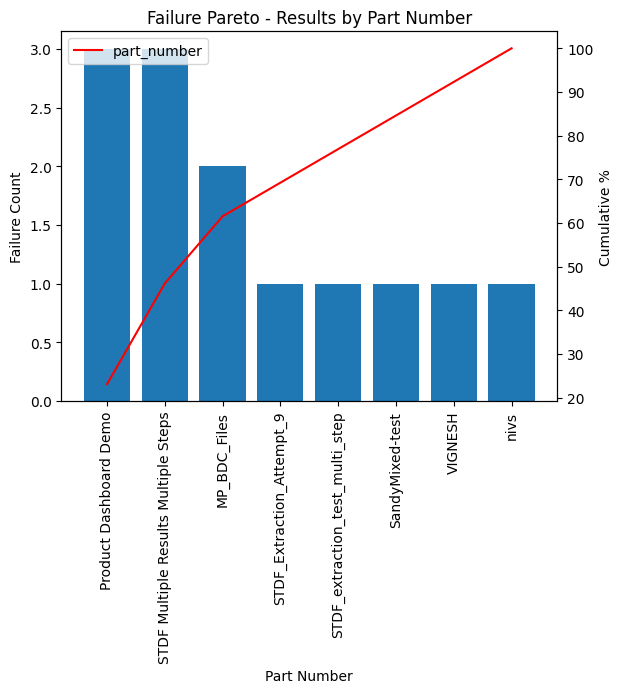

In [15]:
# Extract data from the pareto_graph dictionary
title = pareto_graph['config']['title']
axis_labels = pareto_graph['config']['graph']['axis_labels']
plots = pareto_graph['config']['graph']['plots']

# Plot data
fig, ax1 = plt.subplots()

for plot in plots:
    if plot['style'] == 'BAR':
        ax1.bar(
            df_pareto[plot['x']], 
            df_pareto[plot['y']], 
            label=plot['x'])
        ax1.set_ylabel(axis_labels[1])
        ax1.set_xlabel(axis_labels[0])
    elif plot['style'] == 'LINE':
        ax2 = ax1.twinx()
        ax2.plot(df_pareto[plot['x']], df_pareto[plot['y']], label=plot['x'], color='r')
        ax2.set_ylabel(axis_labels[2])

# Title and legend
plt.title(title)
plt.legend()
ax1.tick_params(axis='x', labelrotation = 90)

# Save as PNG file
plt.savefig(PLOT_FILE_NAME, bbox_inches='tight')

# Show the plot (optional)
plt.show()



### Upload Plot to ni files and link to products

In [16]:
def create_post_request(url, body, headers = None):
    """Post request

    Args:
        url (str): API URL
        body (_type_): Request body
        headers (Dict, optional): API request headers. Defaults to None.

    Returns:
        Response: Post request response
    """
    if not headers:
        headers = {}
    default_headers = {
        "accept": "application/json",
        "Content-Type": "application/json",
        "x-ni-api-key": api_key,
    }
    headers = {**default_headers, **headers}

    return requests.post(
            url,
            json=body,
            headers=headers,
            verify=False,
        )

def upload_file_request(url, file, headers=None):
    if not headers:
        headers = {}
    default_headers = {"accept": "application/json", "x-ni-api-key": api_key}
    headers = {**default_headers, **headers}

    return requests.post(
            url, files=file, headers=headers, verify=False
        )

def upload_file(file_name):
    upload_file_url = f"{ApiUrls.UPLOAD_FILE_URL}?workspace={workspace_id}"
    file = {"file": (file_name, open(file_name, "rb"))}
    response = upload_file_request(upload_file_url, file)
    response.raise_for_status()


    return response.json()

def get_products(part_numbers):
    query_filter = ""
    for part_number in part_numbers[:-1]:
        query_filter += f'partNumber == "{part_number}" or '

    query_filter += f'partNumber == "{part_numbers[-1]}"'
    query_body = {"filter": query_filter}
    response = create_post_request(ApiUrls.QUERY_PRODUCTS_URL, query_body)
    response.raise_for_status()

    return response.json()["products"]


def add_file_id_to_products(part_numbers, file_id):
    products = get_products(part_numbers)
    for product in products:
        product["fileIds"].append(file_id)
    body = {"products": products, "replace": False}
    response = create_post_request(ApiUrls.UPDATE_PRODUCT_URL, body)
    response.raise_for_status()

    return response.json()





In [17]:
upload_file_response = upload_file(file_name=PLOT_FILE_NAME)
uploaded_file_id = upload_file_response["uri"].split("/")[-1]
product_response = add_file_id_to_products(
    part_numbers, file_id=uploaded_file_id
)

### Next Steps

1. Publish this notebook to SystemLink by right-clicking it in the JupyterLab File Browser with the interface as Test Data Analysis.
1. Manually Analyze the results inside results grid by clicking analyze button.